## **Step 1: Fetch Stock Data**
We will use the `yfinance` library to download historical stock data.

In [123]:
import yfinance as yf
import pandas as pd
from datetime import date

# Fetch stock data for NVIDIA (NVDA) between 2020 and 2025
START_DATE = "2020-01-01"
END_DATE = "2025-03-09"
TICKER = "NVDA"

data = yf.download(TICKER, start=START_DATE, end=END_DATE)
data.reset_index(inplace=True)  # Reset index for easier plotting and manipulation



[*********************100%***********************]  1 of 1 completed


## **Step 2: Visualize the Open and Close Prices**
Let's visualize the Open and Close prices for NVIDIA to get an idea of stock trends.

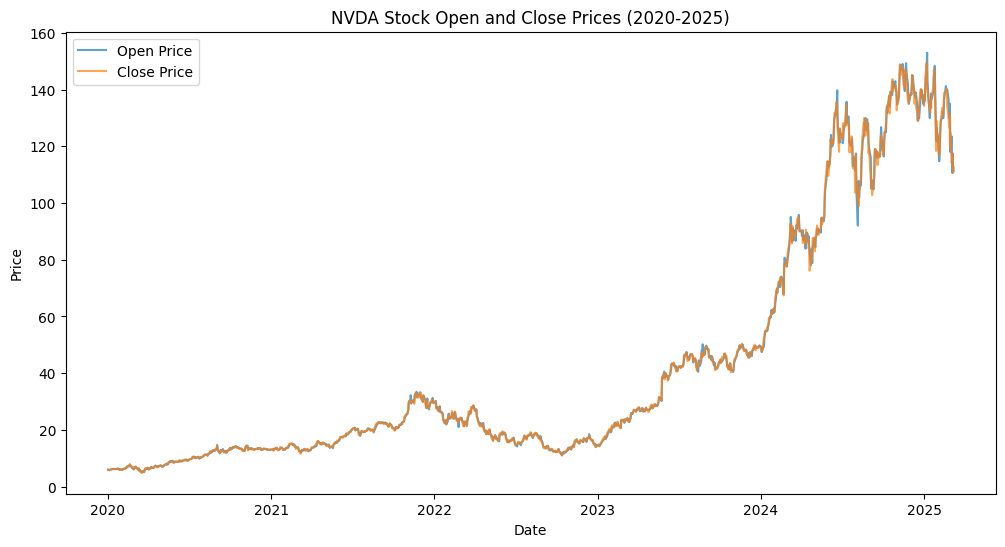

In [124]:
import matplotlib.pyplot as plt

# Plot open and close prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Open'], label="Open Price", alpha=0.7)
plt.plot(data['Date'], data['Close'], label="Close Price", alpha=0.7)
plt.title(f"{TICKER} Stock Open and Close Prices (2020-2025)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()



## **Step 3: Calculate Moving Averages**
To analyze the stock's general trend, calculate **100-day**, **200-day**, and **300-day moving averages** and plot them along with the Close prices.

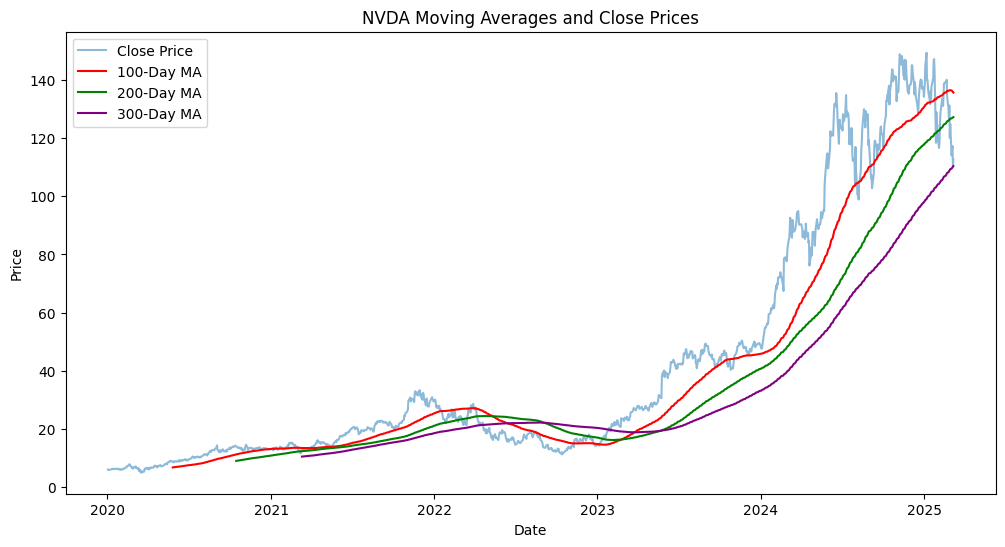

In [125]:
# Add moving averages to DataFrame
data['MA100'] = data['Close'].rolling(100).mean()
data['MA200'] = data['Close'].rolling(200).mean()
data['MA300'] = data['Close'].rolling(300).mean()

# Plot Close Prices with Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label="Close Price", alpha=0.5)
plt.plot(data['Date'], data['MA100'], label="100-Day MA", color="red")
plt.plot(data['Date'], data['MA200'], label="200-Day MA", color="green")
plt.plot(data['Date'], data['MA300'], label="300-Day MA", color="purple")
plt.title(f"{TICKER} Moving Averages and Close Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


## **Step 4: Split Data into Training and Testing**
We will split the data into **80% training** and **20% testing** datasets.

In [126]:
# Define train-test split
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]



## **Step 5: Preprocess the Data**
We need to scale the stock prices to a range between 0 and 1 using **MinMaxScaler** from the `sklearn` library. After scaling, create overlapping sequences of 100 days to use as inputs for the LSTM model.

In [127]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scale data
scaler = MinMaxScaler()
close_prices = data[['Close']]
scaled_data = scaler.fit_transform(close_prices)

# Create sequences of 100 days for training
sequence_length = 100
x_train, y_train = [], []

for i in range(sequence_length, len(train_data)):
    x_train.append(scaled_data[i - sequence_length:i])  # Last 100 days
    y_train.append(scaled_data[i, 0])  # Predict the next day's price

x_train, y_train = np.array(x_train), np.array(y_train)


## **Step 6: Import PyTorch and Define the LSTM Model**
We now define the LSTM model in PyTorch (TensorFlow does not work natively with Apple Silicon). This will take input sequences of 100 days and predict the stock price for the next day.

In [128]:
import torch
import torch.nn as nn
import torch.optim as optim


# Define LSTM model
class StockPriceLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, dropout=0.2):
        super(StockPriceLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Fully connected layer

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Get the output of the last time step
        out = self.fc(out)
        return out


## **Step 7: Convert Data to PyTorch Tensors**
Convert the NumPy arrays for `x_train` and `y_train` to PyTorch tensors, which are required for training the model.

In [129]:
# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Reshape y_train to have an extra dimension
y_train_tensor = y_train_tensor.view(-1, 1)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train_tensor = x_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)


## **Step 8: Initialize the Model, Loss Function, and Optimizer**
Set up the LSTM model and specify the loss function as `MSELoss` (Mean Squared Error) and the `Adam` optimizer.

In [130]:
# Initialize model, loss function, and optimizer
model = StockPriceLSTM(input_size=1, hidden_size=50, num_layers=2, dropout=0.2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## **Step 9: Train the LSTM Model**
Train the LSTM model over several epochs. Use a batch size of 32 for better training stability.

In [131]:
# Train the model
num_epochs = 20
batch_size = 32

# Create data loader for batches
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for x_batch, y_batch in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(x_batch)

        # Compute the loss
        loss = criterion(y_pred, y_batch)

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        epoch_loss += loss.item()

    # Print epoch loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")


Epoch [1/20], Loss: 0.0076
Epoch [2/20], Loss: 0.0012
Epoch [3/20], Loss: 0.0003
Epoch [4/20], Loss: 0.0003
Epoch [5/20], Loss: 0.0003
Epoch [6/20], Loss: 0.0002
Epoch [7/20], Loss: 0.0002
Epoch [8/20], Loss: 0.0002
Epoch [9/20], Loss: 0.0002
Epoch [10/20], Loss: 0.0002
Epoch [11/20], Loss: 0.0002
Epoch [12/20], Loss: 0.0002
Epoch [13/20], Loss: 0.0002
Epoch [14/20], Loss: 0.0002
Epoch [15/20], Loss: 0.0002
Epoch [16/20], Loss: 0.0002
Epoch [17/20], Loss: 0.0002
Epoch [18/20], Loss: 0.0002
Epoch [19/20], Loss: 0.0002
Epoch [20/20], Loss: 0.0002


## **Step 10: Test the Model**
Prepare the test data, make predictions, and inverse scale them back to the original price range.

In [132]:
# Prepare test set
x_test, y_test = [], []
for i in range(len(train_data), len(data) - sequence_length):
    x_test.append(scaled_data[i - sequence_length:i])
    y_test.append(scaled_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    predictions = model(x_test_tensor)

# Inverse transform predictions and actual prices
predictions = predictions.cpu().numpy()
predictions = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


## **Step 11: Plot Predictions vs Actual Prices**
Visualize how well the predictions match the actual prices.

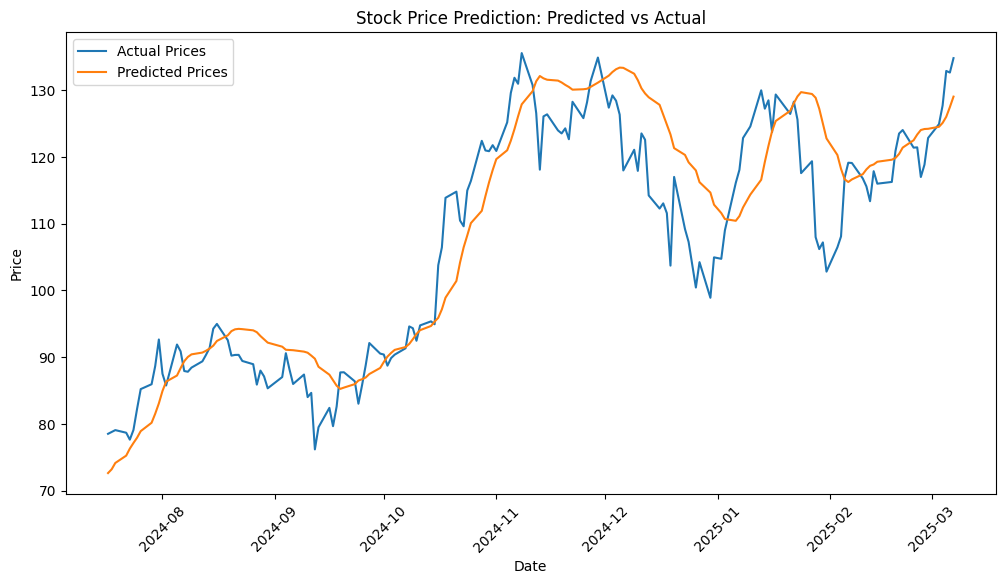

In [133]:
# Plot predicted vs actual prices with actual calendar dates on the x-axis
plt.figure(figsize=(12, 6))
plt.plot(data['Date'][-len(actual_prices):], actual_prices, label="Actual Prices")
plt.plot(data['Date'][-len(predictions):], predictions, label="Predicted Prices")
plt.title("Stock Price Prediction: Predicted vs Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.show()

## **Step 12: Predict the Next Day Price**
Predict the stock price for the next day using the most recent 100 days of data.

In [134]:
# Use the last 100 days of data to predict the next day's price
latest_data = scaled_data[-sequence_length:]
latest_data = torch.tensor(latest_data, dtype=torch.float32).unsqueeze(0).to(device)

with torch.no_grad():
    next_day_prediction = model(latest_data)

# Inverse scale the prediction
next_day_price = scaler.inverse_transform(next_day_prediction.cpu().numpy())
print(f"Predicted Next Day Close Price: {next_day_price[0, 0]:.2f}")

Predicted Next Day Close Price: 125.78


## **Step 13: Compare the Most Recent Price to the Predicted Price**

In this step, we will compare the most recent actual closing stock price to the predicted next day's price from Step 12. This will give us an idea of how close the prediction is to the actual market price.

In [135]:
# Fetch the most recent actual closing price as a float
most_recent_price = float(data['Close'].iloc[-1])

# Ensure next_day_price is a scalar value
predicted_price = float(next_day_price[0, 0])

# Display the comparison
print(f"Most Recent Actual Close Price: {most_recent_price:.2f}")
print(f"Predicted Next Day Close Price: {predicted_price:.2f}")

# Highlight the difference
difference = predicted_price - most_recent_price
p_difference = (difference / most_recent_price) * 100

print(f"Difference: {difference:.2f}")
print(f"Percentage Difference: {p_difference:.2f}%")


Most Recent Actual Close Price: 112.69
Predicted Next Day Close Price: 125.78
Difference: 13.09
Percentage Difference: 11.61%


/var/folders/4n/sprnvzks67jg6yqysvt2lgp80000gn/T/ipykernel_30180/1658510422.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  most_recent_price = float(data['Close'].iloc[-1])
